# Part c

Loading extracted_features.csv...

Task: Binary Classification ['Under-explained', 'Succinct']
Total samples: 339
Total Features Available: 514

ANALYSIS: FEATURE OVERLAP (Task vs. Identity)
Top 50 Task Features: ['tfidf_260', 'tfidf_481', 'tfidf_41']...
Top 50 Identity Features: ['tfidf_228', 'tfidf_431', 'tfidf_399']...

-> Number of Overlapping Features: 11
-> Percentage Overlap: 22%
-> Overlapping Names: ['tfidf_67', 'tfidf_369', 'tfidf_306', 'tfidf_303', 'tfidf_18', 'sentence_count', 'char_count', 'tfidf_101', 'tfidf_128', 'tfidf_48', 'word_count']

EXPERIMENT: CLASSIFICATION (GroupKFold)
Completed experiment for k=10
Completed experiment for k=30
Completed experiment for k=50
Completed experiment for k=100
Completed experiment for k=200

Results by Number of Features (k):
     k  RF_Acc (A)  RF_Bal (BA)  MLP_Acc (A)  MLP_Bal (BA)
0   10      0.7313       0.4342       0.7313        0.4514
1   30      0.8020       0.5216       0.7549        0.5569
2   50      0.8169       0.5151   

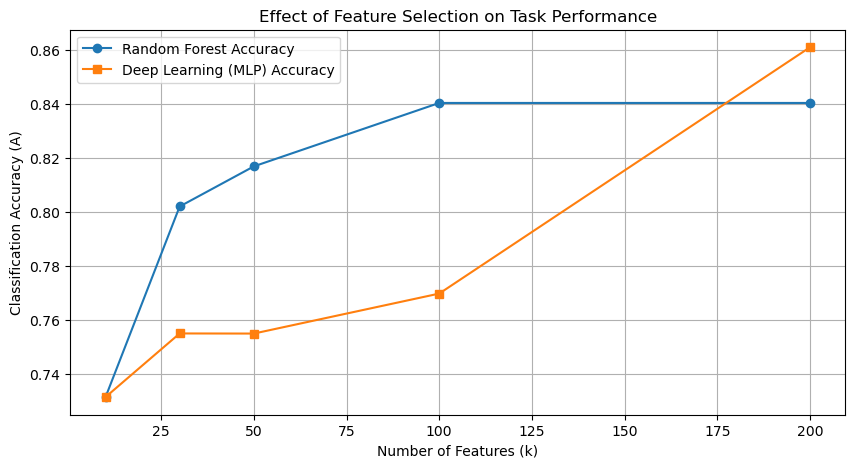


ANALYSIS: SPEAKER FAIRNESS


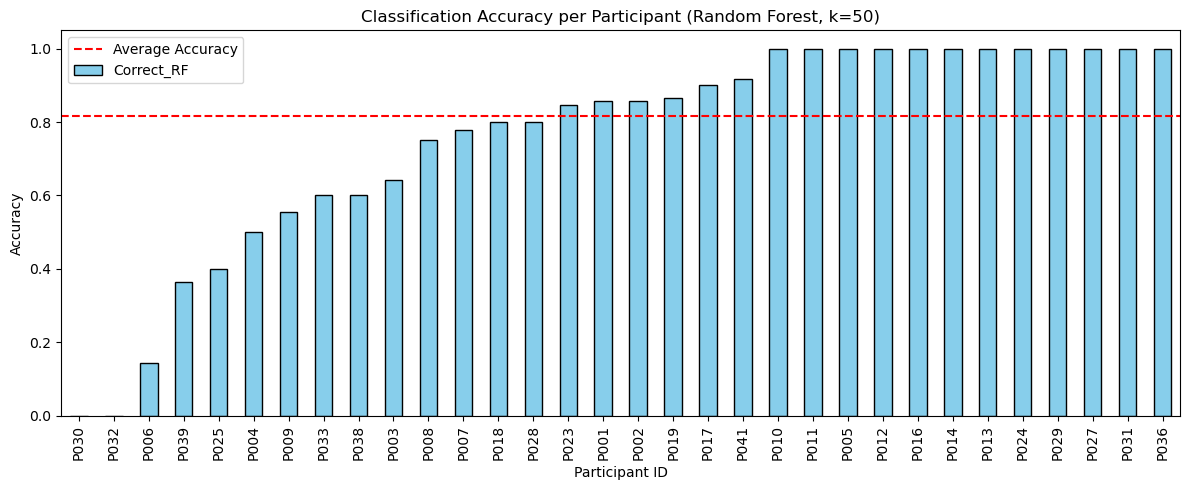

Lowest Performing Speakers (Potential Bias):
Participant
P030    0.000000
P032    0.000000
P006    0.142857
Name: Correct_RF, dtype: float64


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.impute import SimpleImputer
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

def analyze_part_c(filename='extracted_features.csv'):
    print(f"Loading {filename}...")
    try:
        df = pd.read_csv(filename)
    except FileNotFoundError:
        print(f"Error: {filename} not found. Please verify the file path.")
        return

    # 1. PREPARE DATA
    # ----------------
    # Filter for the specific binary task: Under-explained vs Succinct
    target_classes = ['Under-explained', 'Succinct']
    
    # Check for column name variations
    if 'label' not in df.columns:
        cols = [c for c in df.columns if 'Explanation' in c]
        if cols: df.rename(columns={cols[0]: 'label'}, inplace=True)
    if 'participant_id' not in df.columns:
        cols = [c for c in df.columns if 'PID' in c or 'participant' in c.lower()]
        if cols: df.rename(columns={cols[0]: 'participant_id'}, inplace=True)

    # Filter rows
    binary_df = df[df['label'].isin(target_classes)].copy()
    
    print(f"\nTask: Binary Classification {target_classes}")
    print(f"Total samples: {len(binary_df)}")
    
    # Separate Features and Metadata
    metadata_cols = ['participant_id', 'question_id', 'label', 'combined_text', 
                     'answer_text', 'question_text', 'Unnamed: 0']
    
    feature_cols = [c for c in binary_df.columns if c not in metadata_cols and np.issubdtype(binary_df[c].dtype, np.number)]
    
    X = binary_df[feature_cols]
    y_task = binary_df['label']
    groups = binary_df['participant_id'] # For GroupKFold
    
    # Handle NaNs
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    X = pd.DataFrame(imputer.fit_transform(X), columns=feature_cols)
    
    print(f"Total Features Available: {X.shape[1]}")
    
    # 2. DISCUSSION POINT 1: FEATURE OVERLAP
    # ---------------------------------------
    # "Is there overlap between features informative of speaker identity vs task?"
    print("\n" + "="*50)
    print("ANALYSIS: FEATURE OVERLAP (Task vs. Identity)")
    print("="*50)
    
    k_overlap = 50  # Check Top 50 features
    if X.shape[1] < k_overlap: k_overlap = X.shape[1]
    
    # A. Top Features for Task (Under-explained vs Succinct)
    sel_task = SelectKBest(f_classif, k=k_overlap).fit(X, y_task)
    task_feats = set(X.columns[sel_task.get_support()])
    
    # B. Top Features for Identity (Predicting Speaker ID)
    sel_id = SelectKBest(f_classif, k=k_overlap).fit(X, groups)
    id_feats = set(X.columns[sel_id.get_support()])
    
    overlap = task_feats.intersection(id_feats)
    
    print(f"Top {k_overlap} Task Features: {list(task_feats)[:3]}...")
    print(f"Top {k_overlap} Identity Features: {list(id_feats)[:3]}...")
    print(f"\n-> Number of Overlapping Features: {len(overlap)}")
    print(f"-> Percentage Overlap: {len(overlap)/k_overlap:.0%}")
    if overlap:
        print(f"-> Overlapping Names: {list(overlap)}")
        
    # 3. CLASSIFICATION EXPERIMENT
    # -----------------------------
    print("\n" + "="*50)
    print("EXPERIMENT: CLASSIFICATION (GroupKFold)")
    print("="*50)
    
    # Experiment with different k values as requested
    k_values = [10, 30, 50, 100, 200]
    k_values = [k for k in k_values if k <= X.shape[1]]
    
    # Models
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42)
    
    gkf = GroupKFold(n_splits=5)
    results = []
    
    # Storage for fairness analysis (using median k)
    best_k = k_values[len(k_values)//2]
    speaker_stats = []
    
    for k in k_values:
        fold_res = {'rf_acc': [], 'rf_bal': [], 'mlp_acc': [], 'mlp_bal': []}
        
        for train_idx, test_idx in gkf.split(X, y_task, groups=groups):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y_task.iloc[train_idx], y_task.iloc[test_idx]
            
            # Feature Selection (Filter Method inside CV loop)
            selector = SelectKBest(f_classif, k=k)
            X_train_sel = selector.fit_transform(X_train, y_train)
            X_test_sel = selector.transform(X_test)
            
            # Scale for MLP
            scaler = StandardScaler()
            X_train_sc = scaler.fit_transform(X_train_sel)
            X_test_sc = scaler.transform(X_test_sel)
            
            # Train & Evaluate RF
            rf.fit(X_train_sel, y_train)
            y_pred_rf = rf.predict(X_test_sel)
            fold_res['rf_acc'].append(accuracy_score(y_test, y_pred_rf))
            fold_res['rf_bal'].append(balanced_accuracy_score(y_test, y_pred_rf))
            
            # Train & Evaluate MLP
            mlp.fit(X_train_sc, y_train)
            y_pred_mlp = mlp.predict(X_test_sc)
            fold_res['mlp_acc'].append(accuracy_score(y_test, y_pred_mlp))
            fold_res['mlp_bal'].append(balanced_accuracy_score(y_test, y_pred_mlp))
            
            # Collect data for Speaker Analysis (only for one specific k)
            if k == best_k:
                pids = groups.iloc[test_idx].values
                for i, pid in enumerate(pids):
                    speaker_stats.append({
                        'Participant': pid,
                        'Correct_RF': y_test.iloc[i] == y_pred_rf[i]
                    })
                    
        results.append({
            'k': k,
            'RF_Acc (A)': np.mean(fold_res['rf_acc']),
            'RF_Bal (BA)': np.mean(fold_res['rf_bal']),
            'MLP_Acc (A)': np.mean(fold_res['mlp_acc']),
            'MLP_Bal (BA)': np.mean(fold_res['mlp_bal'])
        })
        print(f"Completed experiment for k={k}")
        
    res_df = pd.DataFrame(results)
    print("\nResults by Number of Features (k):")
    print(res_df.round(4))
    
    # 4. PLOTTING & ANALYSIS
    # -----------------------
    # A. Performance Plot
    plt.figure(figsize=(10, 5))
    plt.plot(res_df['k'], res_df['RF_Acc (A)'], marker='o', label='Random Forest Accuracy')
    plt.plot(res_df['k'], res_df['MLP_Acc (A)'], marker='s', label='Deep Learning (MLP) Accuracy')
    plt.xlabel('Number of Features (k)')
    plt.ylabel('Classification Accuracy (A)')
    plt.title('Effect of Feature Selection on Task Performance')
    plt.legend()
    plt.grid(True)
    plt.savefig('task_performance_k.png')
    plt.show()
    
    # B. Speaker Fairness Plot
    if speaker_stats:
        print("\n" + "="*50)
        print("ANALYSIS: SPEAKER FAIRNESS")
        print("="*50)
        
        sp_df = pd.DataFrame(speaker_stats)
        sp_acc = sp_df.groupby('Participant')['Correct_RF'].mean().sort_values()
        
        plt.figure(figsize=(12, 5))
        sp_acc.plot(kind='bar', color='skyblue', edgecolor='black')
        plt.axhline(y=sp_df['Correct_RF'].mean(), color='r', linestyle='--', label='Average Accuracy')
        plt.title(f'Classification Accuracy per Participant (Random Forest, k={best_k})')
        plt.ylabel('Accuracy')
        plt.xlabel('Participant ID')
        plt.legend()
        plt.tight_layout()
        plt.savefig('speaker_fairness.png')
        plt.show()
        
        print("Lowest Performing Speakers (Potential Bias):")
        print(sp_acc.head(3))

# Run the function
if __name__ == "__main__":
    analyze_part_c('extracted_features.csv')

# Part d

Loading extracted_features.csv...

Task: Binary Classification ['Comprehensive', 'Over-explained']
Total samples: 460
Class Distribution:
label
Comprehensive     341
Over-explained    119
Name: count, dtype: int64

DISCUSSION POINT 1: OVERLAP (Task vs Identity)
Overlapping Features: 9 (18%)
Overlap Examples: ['tfidf_116', 'tfidf_139', 'tfidf_70', 'tfidf_242', 'avg_sentence_length']

CLASSIFICATION EXPERIMENT
Finished k=10
Finished k=30
Finished k=50
Finished k=100
Finished k=200

Results Summary:
     k  RF_Acc  RF_Bal  MLP_Acc  MLP_Bal
0   10  0.7001  0.5706   0.6547   0.4620
1   30  0.6940  0.5498   0.6288   0.4490
2   50  0.7092  0.5473   0.6086   0.4325
3  100  0.7200  0.5517   0.6503   0.4529
4  200  0.7070  0.5424   0.6487   0.4487


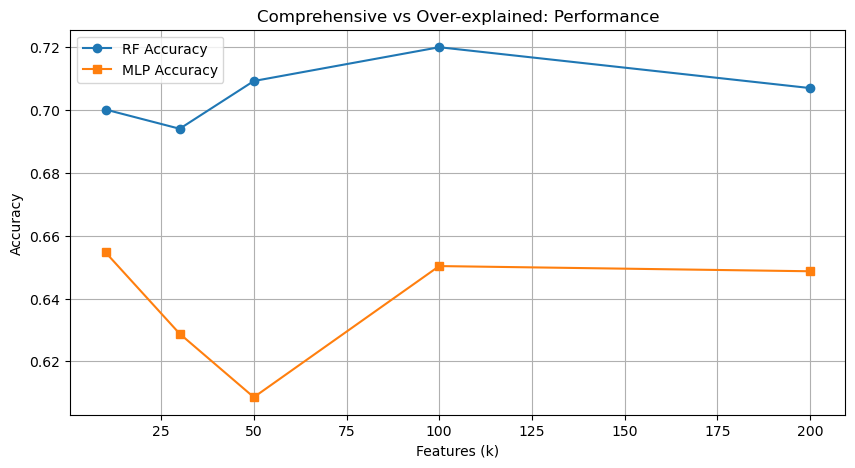

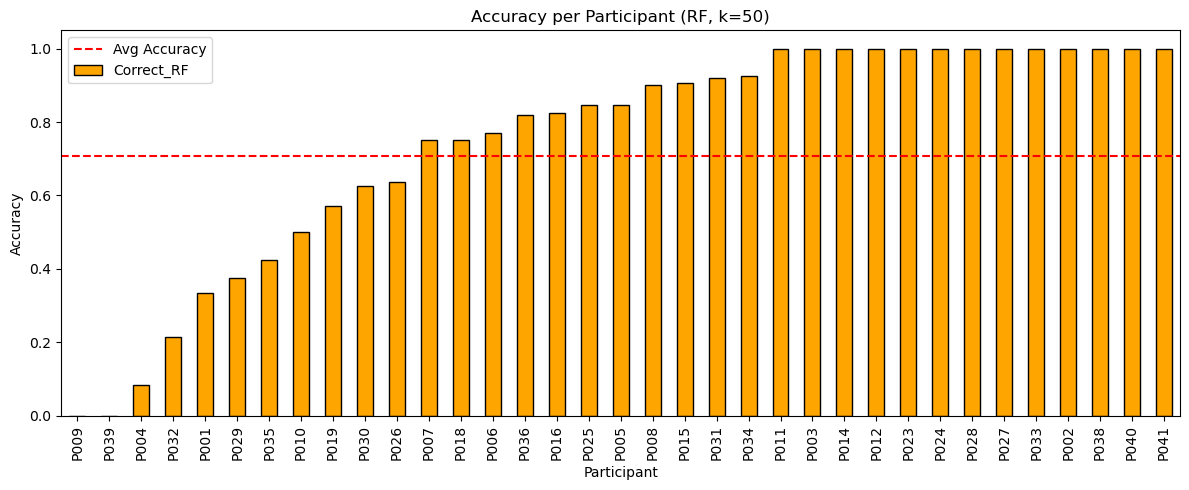

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.impute import SimpleImputer
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

def analyze_part_d(filename='extracted_features.csv'):
    print(f"Loading {filename}...")
    try:
        df = pd.read_csv(filename)
    except FileNotFoundError:
        print(f"Error: {filename} not found.")
        return

    # 1. PREPARE DATA
    # ----------------
    # Filter for: Comprehensive vs Over-explained
    target_classes = ['Comprehensive', 'Over-explained']
    
    # Standardize columns
    if 'label' not in df.columns:
        cols = [c for c in df.columns if 'Explanation' in c]
        if cols: df.rename(columns={cols[0]: 'label'}, inplace=True)
    if 'participant_id' not in df.columns:
        cols = [c for c in df.columns if 'PID' in c]
        if cols: df.rename(columns={cols[0]: 'participant_id'}, inplace=True)

    # Filter rows
    binary_df = df[df['label'].isin(target_classes)].copy()
    
    print(f"\nTask: Binary Classification {target_classes}")
    print(f"Total samples: {len(binary_df)}")
    print(f"Class Distribution:\n{binary_df['label'].value_counts()}")
    
    # Check if we have enough data (Over-explained is rare, ~34 samples)
    if len(binary_df) < 10:
        print("Error: Not enough samples to run analysis.")
        return

    # Separate Features
    metadata_cols = ['participant_id', 'question_id', 'label', 'combined_text', 
                     'answer_text', 'question_text', 'Unnamed: 0']
    feature_cols = [c for c in binary_df.columns if c not in metadata_cols and np.issubdtype(binary_df[c].dtype, np.number)]
    
    X = binary_df[feature_cols]
    y_task = binary_df['label']
    groups = binary_df['participant_id']
    
    imputer = SimpleImputer(strategy='constant', fill_value=0)
    X = pd.DataFrame(imputer.fit_transform(X), columns=feature_cols)
    
    # 2. FEATURE OVERLAP ANALYSIS
    # ----------------------------
    print("\n" + "="*50)
    print("DISCUSSION POINT 1: OVERLAP (Task vs Identity)")
    print("="*50)
    
    k_overlap = 50
    if X.shape[1] < k_overlap: k_overlap = X.shape[1]
    
    # Task Features
    sel_task = SelectKBest(f_classif, k=k_overlap).fit(X, y_task)
    task_feats = set(X.columns[sel_task.get_support()])
    
    # Identity Features
    sel_id = SelectKBest(f_classif, k=k_overlap).fit(X, groups)
    id_feats = set(X.columns[sel_id.get_support()])
    
    overlap = task_feats.intersection(id_feats)
    
    print(f"Overlapping Features: {len(overlap)} ({len(overlap)/k_overlap:.0%})")
    if overlap:
        print(f"Overlap Examples: {list(overlap)[:5]}")

    # 3. CLASSIFICATION EXPERIMENT
    # -----------------------------
    print("\n" + "="*50)
    print("CLASSIFICATION EXPERIMENT")
    print("="*50)
    
    k_values = [10, 30, 50, 100, 200]
    k_values = [k for k in k_values if k <= X.shape[1]]
    
    # Note: increased max_iter because distinguishing Comp/Over is harder
    rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
    mlp = MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=2000, random_state=42)
    
    gkf = GroupKFold(n_splits=5)
    results = []
    
    best_k = k_values[len(k_values)//2]
    speaker_stats = []
    
    for k in k_values:
        fold_res = {'rf_acc': [], 'rf_bal': [], 'mlp_acc': [], 'mlp_bal': []}
        
        for train_idx, test_idx in gkf.split(X, y_task, groups=groups):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y_task.iloc[train_idx], y_task.iloc[test_idx]
            
            # Select
            sel = SelectKBest(f_classif, k=k)
            X_train_sel = sel.fit_transform(X_train, y_train)
            X_test_sel = sel.transform(X_test)
            
            # Scale
            scaler = StandardScaler()
            X_train_sc = scaler.fit_transform(X_train_sel)
            X_test_sc = scaler.transform(X_test_sel)
            
            # Train/Predict
            rf.fit(X_train_sel, y_train)
            y_pred_rf = rf.predict(X_test_sel)
            
            mlp.fit(X_train_sc, y_train)
            y_pred_mlp = mlp.predict(X_test_sc)
            
            fold_res['rf_acc'].append(accuracy_score(y_test, y_pred_rf))
            fold_res['rf_bal'].append(balanced_accuracy_score(y_test, y_pred_rf))
            fold_res['mlp_acc'].append(accuracy_score(y_test, y_pred_mlp))
            fold_res['mlp_bal'].append(balanced_accuracy_score(y_test, y_pred_mlp))
            
            if k == best_k:
                pids = groups.iloc[test_idx].values
                for i, pid in enumerate(pids):
                    speaker_stats.append({
                        'Participant': pid,
                        'Correct_RF': y_test.iloc[i] == y_pred_rf[i],
                        'True_Label': y_test.iloc[i]
                    })
        
        results.append({
            'k': k,
            'RF_Acc': np.mean(fold_res['rf_acc']),
            'RF_Bal': np.mean(fold_res['rf_bal']),
            'MLP_Acc': np.mean(fold_res['mlp_acc']),
            'MLP_Bal': np.mean(fold_res['mlp_bal'])
        })
        print(f"Finished k={k}")

    res_df = pd.DataFrame(results)
    print("\nResults Summary:")
    print(res_df.round(4))
    
    # 4. PLOTS
    # --------
    # Performance
    plt.figure(figsize=(10, 5))
    plt.plot(res_df['k'], res_df['RF_Acc'], marker='o', label='RF Accuracy')
    plt.plot(res_df['k'], res_df['MLP_Acc'], marker='s', label='MLP Accuracy')
    plt.title('Comprehensive vs Over-explained: Performance')
    plt.xlabel('Features (k)')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.savefig('part_d_performance.png')
    plt.show()
    
    # Fairness
    if speaker_stats:
        sp_df = pd.DataFrame(speaker_stats)
        # Sort by accuracy
        sp_acc = sp_df.groupby('Participant')['Correct_RF'].mean().sort_values()
        
        plt.figure(figsize=(12, 5))
        sp_acc.plot(kind='bar', color='orange', edgecolor='black')
        plt.axhline(y=sp_df['Correct_RF'].mean(), color='r', linestyle='--', label='Avg Accuracy')
        plt.title(f'Accuracy per Participant (RF, k={best_k})')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.tight_layout()
        plt.savefig('part_d_fairness.png')
        plt.show()

if __name__ == "__main__":
    analyze_part_d('extracted_features.csv')